In [ ]:
#Extract Covid Cohen

import numpy as np
import cv2
import pandas as pd
from glob import glob
import os


img_path = 'D:\\University\\Master\\Term 3\\Computer Vision\\HWs\\Project I\\Dataset\\images\*'
csv_path = 'D:\\University\\Master\\Term 3\\Computer Vision\\HWs\\Project I\\Dataset\\metadata.csv'
save_path = 'D:\\University\\Master\\Term 3\\Computer Vision\\HWs\\Project I\\COVID-19 dataset\\Covid'
save_path2 = 'D:\\University\\Master\\Term 3\\Computer Vision\\HWs\\Project I\\COVID-19 dataset\\Normal'

path_img = sorted(glob(img_path))
csv_file = pd.read_csv(csv_path)
flag = 'COVID-19'

for i in range(csv_file.shape[0]):
    
    finding = csv_file['finding'][i]
    if flag in finding:
        filename = os.path.splitext(csv_file['filename'][i])[0]
        for img_path in path_img:
            img_name = os.path.splitext(os.path.basename(img_path))[0]
            if img_name == filename:
                img = cv2.imread(img_path)
                cv2.imwrite(save_path + '\Covid_'+os.path.basename(img_path), img)
    else: 
        filename = os.path.splitext(csv_file['filename'][i])[0]
        for img_path in path_img:
            img_name = os.path.splitext(os.path.basename(img_path))[0]
            if img_name == filename:
                img = cv2.imread(img_path)
                cv2.imwrite(save_path2 + '\\Normal_'+os.path.basename(img_path), img)




In [1]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm

def calculate_overall_mean_std(data_path, subset_ratio=0.7, target_size=(224, 224)):
    """
    Calculate the overall mean and standard deviation for 70% of the images from both classes (Covid and Normal).
    
    Args:
    data_path (str): Path to the dataset containing 'Covid' and 'Normal' subfolders.
    subset_ratio (float): Proportion of images to use for calculating statistics (default is 70%).
    target_size (tuple): Target size for resizing images.
    
    Returns:
    - overall_mean (list): Overall mean values for (R, G, B).
    - overall_std (list): Overall standard deviation values for (R, G, B).
    """
    image_paths = []

    # Collect image paths for both classes (Covid and Normal)
    for root, subfolders, filenames in os.walk(data_path):
        for k in subfolders:
            if k == 'Covid' or k == 'Normal':  # Collect paths for both 'Covid' and 'Normal'
                filepath = os.path.join(root, k, "*")
                paths = sorted(glob(filepath))
                image_paths.extend(paths)

    # Shuffle the image paths to ensure randomness
    np.random.shuffle(image_paths)
    
    # Select 70% of the images for training
    train_paths = image_paths[:int(len(image_paths) * subset_ratio)]

    # Initialize variables to calculate mean and std
    pixel_sum = np.zeros(3)
    pixel_sq_sum = np.zeros(3)
    num_pixels = 0

    # Iterate over the selected 70% images
    for img_path in tqdm(train_paths, desc="Calculating Overall Mean and Std"):
        try:
            # Read the image
            img = cv2.imread(img_path)
            if img is None:
                print(f"Could not read image: {img_path}")
                continue

            # Resize the image
            img_resized = cv2.resize(img, target_size)

            # Normalize to [0, 1]
            img_resized = img_resized / 255.0  # Scaling to [0, 1]

            # Accumulate pixel sums and squared sums
            pixel_sum += np.sum(img_resized, axis=(0, 1))
            pixel_sq_sum += np.sum(img_resized**2, axis=(0, 1))
            num_pixels += img_resized.shape[0] * img_resized.shape[1]  # Total pixels per image

        except Exception as e:
            print(f"Error processing {img_path}: {e}")

    # Calculate overall mean and std
    overall_mean = pixel_sum / num_pixels
    overall_std = np.sqrt((pixel_sq_sum / num_pixels) - (overall_mean**2))

    return overall_mean.tolist(), overall_std.tolist()

# Example usage
data_path = r"D:\University\Master\Term 3\Computer Vision\HWs\Project I\Attempt 2\MachineVision Dataset\Dataset"
overall_mean, overall_std = calculate_overall_mean_std(data_path)

print(f"Overall Mean: {overall_mean}")
print(f"Overall Std: {overall_std}")


Calculating Overall Mean and Std: 100%|██████████| 2100/2100 [00:59<00:00, 35.20it/s]

Overall Mean: [0.5113713164952965, 0.5111083020633332, 0.5110829029900134]
Overall Std: [0.2556174130529046, 0.2555650771697803, 0.2555635740709926]


In [2]:
import numpy as np
import cv2
import os
from glob import glob
from tqdm import tqdm
import torch
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def create_dataset_folders(data_path, created_path, split_ratio=0.7, num_class=2, image_size=224):
    """
    Separate image dataset into train, validation, and test sets with preprocessing.
    
    Args:
    data_path (str): Path to the original dataset
    created_path (str): Path where separated dataset will be created
    split_ratio (float): Proportion of data to be used for training
    num_class (int): Number of classes in the dataset
    image_size (int): Size to resize images to
    """
    # Create transforms for preprocessing
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5114, 0.5111, 0.5111], std=[0.2556, 0.2556, 0.2556])
    ])
    
    for root, subfolders, filenames in os.walk(data_path):
        if len(subfolders) == num_class:
            for k in subfolders:
                # Create output directories if they don't exist
                os.makedirs(os.path.join(created_path, "Train", k), exist_ok=True)
                os.makedirs(os.path.join(created_path, "Valid", k), exist_ok=True)
                os.makedirs(os.path.join(created_path, "Test", k), exist_ok=True)
                
                # Get all image paths for this class
                filepath = os.path.join(root, k, "*")
                paths = sorted(glob(filepath))
                
                # Calculate split indices
                total_images = len(paths)
                train_count = int(total_images * 0.7)  # 70% train
                valid_count = int(total_images * 0.2)  # 20% validation
                test_count = total_images - train_count - valid_count  # 10% test
                
                # Shuffle paths to ensure random distribution
                np.random.seed(42)  # for reproducibility
                np.random.shuffle(paths)
                
                # Split and save images
                for i, img_path in tqdm(enumerate(paths), total=total_images, desc=f"Processing {k} class"):
                    try:
                        # Read image
                        img = cv2.imread(img_path)
                        
                        # Check if image is loaded successfully
                        if img is None:
                            print(f"Could not read image: {img_path}")
                            continue
                        
                        # Convert BGR to RGB (OpenCV reads in BGR)
                        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        
                        # Apply preprocessing
                        img_preprocessed = transform(img_rgb)
                        
                        # Convert tensor back to numpy for saving
                        img_to_save = (img_preprocessed.numpy() * 255).astype(np.uint8)
                        img_to_save = np.transpose(img_to_save, (1, 2, 0))
                        
                        # Generate unique filename
                        class_name = os.path.basename(img_path)
                        unique_filename = f"{os.path.splitext(class_name)[0]}_{i}.jpg"
                        
                        if i < train_count:
                            # Train set
                            cv2.imwrite(os.path.join(created_path, "Train", k, unique_filename), 
                                        cv2.cvtColor(img_to_save, cv2.COLOR_RGB2BGR))
                        elif i < train_count + valid_count:
                            # Validation set
                            cv2.imwrite(os.path.join(created_path, "Valid", k, unique_filename), 
                                        cv2.cvtColor(img_to_save, cv2.COLOR_RGB2BGR))
                        else:
                            # Test set
                            cv2.imwrite(os.path.join(created_path, "Test", k, unique_filename), 
                                        cv2.cvtColor(img_to_save, cv2.COLOR_RGB2BGR))
                    
                    except Exception as e:
                        print(f"Error processing {img_path}: {e}")

def print_dataset_stats(created_path):
    """
    Print statistics about the created dataset
    
    Args:
    created_path (str): Path where the dataset was created
    """
    print("\nDataset Statistics:")
    for split in ['Train', 'Valid', 'Test']:
        print(f"\n{split} Set:")
        for class_dir in os.listdir(os.path.join(created_path, split)):
            class_path = os.path.join(created_path, split, class_dir)
            num_images = len(os.listdir(class_path))
            print(f"{class_dir}: {num_images} images")

def main():
    # Paths
    data_path = r"D:\University\Master\Term 3\Computer Vision\HWs\Project I\Attempt 2\MachineVision Dataset\Dataset"
    create_path = r"D:\University\Master\Term 3\Computer Vision\HWs\Project I\Improvement\MachineVision Dataset\Final dataset seperated"
    
    # Ensure created path exists
    os.makedirs(create_path, exist_ok=True)
    
    # Create dataset
    create_dataset_folders(
        data_path=data_path, 
        created_path=create_path, 
        split_ratio=0.7, 
        num_class=2,  # Adjust based on your dataset
        image_size=224
    )
    
    # Print dataset statistics
    print_dataset_stats(create_path)

if __name__ == '__main__':
    main()

Processing Normal class: 100%|██████████| 1500/1500 [01:06<00:00, 22.49it/s]


Dataset Statistics:

Train Set:
Covid: 1050 images
Normal: 1050 images

Valid Set:
Covid: 300 images
Normal: 300 images

Test Set:
Covid: 150 images
Normal: 150 images


Found 1680 images belonging to 2 classes.
Found 420 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Epoch 1/50
112/112 [==============================] - ETA: 0s - loss: 0.6983 - accuracy: 0.5077
Epoch 1: val_loss improved from inf to 0.69106, saving model to D:\University\Master\Term 3\Computer Vision\HWs\Project I\Improvement\cnn_model_improved.h5
112/112 [==============================] - 46s 304ms/step - loss: 0.6983 - accuracy: 0.5077 - val_loss: 0.6911 - val_accuracy: 0.5929
Epoch 2/50
112/112 [==============================] - ETA: 0s - loss: 0.6903 - accuracy: 0.5274
Epoch 2: val_loss improved from 0.69106 to 0.68524, saving model to D:\University\Master\Term 3\Computer Vision\HWs\Project I\Improvement\cnn_model_improved.h5
112/112 [==============================] - 20s 178ms/step - loss: 0.6903 - accuracy: 0.5274 - val_loss: 0.6852 - val_accuracy: 0.6333
Epoch 3/50
112/112 [==============================] - ETA: 0s - loss: 0.6677 - accuracy: 0.6095
Epoc

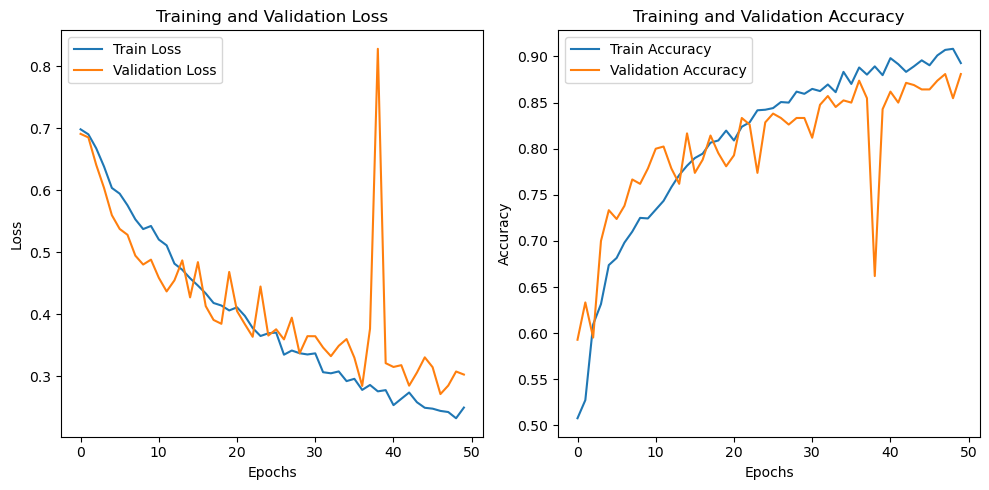

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# Ensure reproducibility
tf.random.set_seed(42)
np.random.seed(42)

def create_cnn_model(input_shape=(224, 224, 3)):
    model = models.Sequential([
        # Layer 1: Conv2D: to extract spatial features
        layers.Conv2D(32, (3, 3), strides=1, padding='valid', activation='relu', input_shape=input_shape),
        
        # Layer 2: Conv2D: to extract spatial features
        layers.Conv2D(128, (3, 3), strides=1, padding='valid', activation='relu'),
        
        # Layer 3: MaxPooling: to reduce spatial dimensions
        layers.MaxPooling2D((2, 2), strides=2),
        
        # Layer 4: Dropout
        layers.Dropout(0.25),
        
        # Layer 5: Conv2D: to extract spatial features
        layers.Conv2D(64, (3, 3), strides=1, padding='valid', activation='relu'),
        
        # Layer 6: MaxPooling: to reduce spatial dimensions
        layers.MaxPooling2D((2, 2), strides=2),
        
        # Layer 7: Dropout
        layers.Dropout(0.25),
        
        # Layer 8: Conv2D: to extract spatial features
        layers.Conv2D(128, (3, 3), strides=1, padding='valid', activation='relu'),
        
        # Layer 9: MaxPooling: to reduce spatial dimensions
        layers.MaxPooling2D((2, 2), strides=2),
        
        # Layer 10: Dropout
        layers.Dropout(0.25),
        
        # Layer 11: Conv2D: to extract spatial features
        layers.Conv2D(512, (3, 3), strides=1, padding='valid', activation='relu'),
        
        # Layer 12: MaxPooling: to reduce spatial dimensions
        layers.MaxPooling2D((2, 2), strides=2),
        
        # Layer 13: Dropout
        layers.Dropout(0.25),
        
        # Layer 14: Conv2D: to extract spatial features
        layers.Conv2D(512, (3, 3), strides=1, padding='valid', activation='relu'),
        
        # Layer 15: MaxPooling: to reduce spatial dimensions
        layers.MaxPooling2D((2, 2), strides=2),
        
        # Layer 16: Dropout
        layers.Dropout(0.25),
        
        # Layer 17: Flatten
        layers.Flatten(),
        
        # Layer 18: Fully Connected Layer
        layers.Dense(64, activation='relu'),
        
        # Layer 19: Dropout
        layers.Dropout(0.25),
        
        # Layer 20: Output Layer
        layers.Dense(2, activation='sigmoid')
    ])
    
    return model

def main():
    # Configurations
    train_dir = r'D:\University\Master\Term 3\Computer Vision\HWs\Project I\Improvement\MachineVision Dataset\Final dataset seperated\Train'
    valid_dir = r'D:\University\Master\Term 3\Computer Vision\HWs\Project I\Improvement\MachineVision Dataset\Final dataset seperated\Valid'
    test_dir = r'D:\University\Master\Term 3\Computer Vision\HWs\Project I\Improvement\MachineVision Dataset\Final dataset seperated\Test'
    save_path = r'D:\University\Master\Term 3\Computer Vision\HWs\Project I\Improvement\cnn_model_improved.h5'
    Train_flag = True

    # Data Augmentation and Preprocessing
    train_datagen = ImageDataGenerator(
        rescale=1./255, 
        rotation_range=20,  # X-ray images don’t require aggressive augmentation
        width_shift_range=0.2,  
        height_shift_range=0.2,
        horizontal_flip=True, # Avoid unrealistic augmentations for medical data
        validation_split=0.2
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    # Load and Prepare Datasets
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=15,
        class_mode='categorical',
        subset='training'
    )

    valid_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=15,
        class_mode='categorical',
        subset='validation'
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=460,
        class_mode='categorical',
        shuffle=False
    )

    if Train_flag:
        # Create and Compile Model
        model = create_cnn_model()
        model.compile(
            optimizer=optimizers.RMSprop(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Model Checkpoint
        checkpoint = ModelCheckpoint(
            save_path, 
            monitor='val_loss', 
            save_best_only=True, 
            mode='min', 
            verbose=1
        )

        # Training
        history = model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples // train_generator.batch_size,
            validation_data=valid_generator,
            validation_steps=valid_generator.samples // valid_generator.batch_size,
            epochs=50,
            callbacks=[checkpoint]
        )

        # Plot Training History
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title('Training and Validation Loss')
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.title('Training and Validation Accuracy')
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.tight_layout()
        plt.show()

    else:
        # Testing Phase
        model = tf.keras.models.load_model(save_path)

        # Evaluate on Test Data
        test_loss, test_accuracy = model.evaluate(test_generator)
        
        # Predictions
        predictions = model.predict(test_generator)
        y_pred = np.argmax(predictions, axis=1)
        y_true = test_generator.classes

        # Confusion Matrix
        from sklearn.metrics import confusion_matrix, classification_report
        cm = confusion_matrix(y_true, y_pred)
        
        # Plot Confusion Matrix
        import seaborn as sns
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Normal', 'Covid'], 
                    yticklabels=['Normal', 'Covid'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        # Classification Report
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=['Normal', 'Covid']))

        # Additional Metrics
        from sklearn.metrics import precision_score, recall_score, f1_score
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

        print(f"\nTest Loss: {test_loss:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")

if __name__ == '__main__':
    main()

In [2]:
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import os

class COVIDClassificationApp:
    def __init__(self, master):
        self.master = master
        master.title("COVID-19 X-ray Classification")
        master.geometry("800x600")
        master.configure(bg='#f0f0f0')

        # Load pre-trained TensorFlow model
        self.save_path = r'D:\University\Master\Term 3\Computer Vision\HWs\Project I\Improvement\cnn_model_improved.h5'  # Update this with your actual model path
        self.model = load_model(self.save_path)

        # Image preprocessing transformations
        self.input_shape = (224, 224)  # Adjust based on your model's input size

        # Create UI components
        self.create_widgets()

    def create_widgets(self):
        # Image Display Frame
        self.image_frame = tk.Frame(self.master, width=500, height=400, bg='white', relief=tk.RAISED, borderwidth=2)
        self.image_frame.pack(pady=20)
        self.image_frame.pack_propagate(False)

        self.image_label = tk.Label(self.image_frame, text="No Image Selected", bg='white')
        self.image_label.pack(expand=True)

        # Button Frame
        button_frame = tk.Frame(self.master, bg='#f0f0f0')
        button_frame.pack(pady=10)

        # Select Image Button
        select_button = tk.Button(button_frame, text="Select Image", command=self.select_image, 
                                  bg='#4CAF50', fg='white', font=('Arial', 12))
        select_button.pack(side=tk.LEFT, padx=10)

        # Classify Button
        classify_button = tk.Button(button_frame, text="Classify Image", command=self.classify_image, 
                                    bg='#2196F3', fg='white', font=('Arial', 12))
        classify_button.pack(side=tk.LEFT, padx=10)

        # Result Frame
        self.result_frame = tk.Frame(self.master, width=600, height=100, bg='#e0e0e0', relief=tk.SUNKEN, borderwidth=2)
        self.result_frame.pack(pady=10)
        self.result_frame.pack_propagate(False)

        self.result_label = tk.Label(self.result_frame, text="Classification Result", 
                                     bg='#e0e0e0', font=('Arial', 14))
        self.result_label.pack(expand=True)

        # Class labels
        self.class_labels = ["Normal", "COVID-19"]

        # Store selected image path
        self.selected_image_path = None

    def select_image(self):
        # Open file dialog to select image
        file_path = filedialog.askopenfilename(
            title="Select X-ray Image",
            filetypes=[("Image files", "*.png *.jpg *.jpeg *.bmp *.tiff")]
        )
        
        if file_path:
            self.selected_image_path = file_path
            # Display selected image
            image = Image.open(file_path)
            image.thumbnail((500, 400))  # Resize for display
            photo = ImageTk.PhotoImage(image)
            
            self.image_label.configure(image=photo)
            self.image_label.image = photo  # Keep a reference
            
            # Reset result label
            self.result_label.configure(text="Image Selected. Ready to Classify.")

    
    def classify_image(self):
        if not self.selected_image_path:
            messagebox.showwarning("Warning", "Please select an image first!")
            return

        try:
            # Open and preprocess image
            image = Image.open(self.selected_image_path).convert('RGB')
            image = image.resize(self.input_shape)  # Resize to match model input
            
            # Convert to numpy array and normalize
            img_array = img_to_array(image)
            img_array = img_array / 255.0  # Normalize to [0,1]
            img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

            # Perform classification
            prediction = self.model.predict(img_array)
            predicted_class = np.argmax(prediction, axis=1)[0]
            confidence = np.max(prediction) * 100

            # Update result label
            result_text = f"Prediction: {self.class_labels[predicted_class]}\n" \
                          f"Confidence: {confidence:.2f}%"
            self.result_label.configure(text=result_text, fg='green')

        except Exception as e:
            messagebox.showerror("Error", f"An error occurred: {str(e)}")

def main():
    root = tk.Tk()
    app = COVIDClassificationApp(root)
    root.mainloop()

if __name__ == "__main__":
    main()


1/1 [==============================] - 0s 20ms/step


Train data shape: (2100, 64)
Test data shape: (300, 64)
Train label distribution:
 (array([0, 1], dtype=int64), array([1050, 1050], dtype=int64))
Test label distribution:
 (array([0, 1], dtype=int64), array([150, 150], dtype=int64))
Confusion Matrix Shape: (2, 2)
Confusion Matrix:
 [[125  25]
 [ 47 103]]


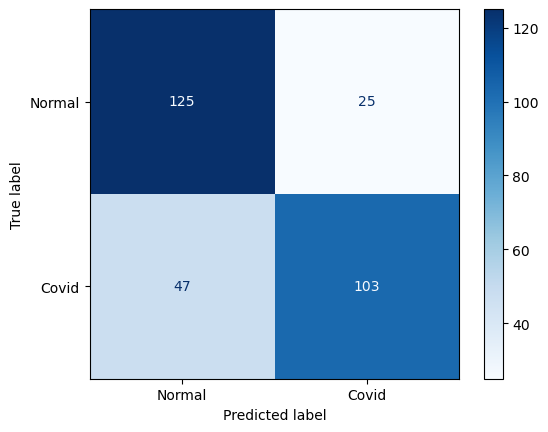

Confusion Matrix Shape: (2, 2)
Confusion Matrix:
 [[130  20]
 [ 32 118]]


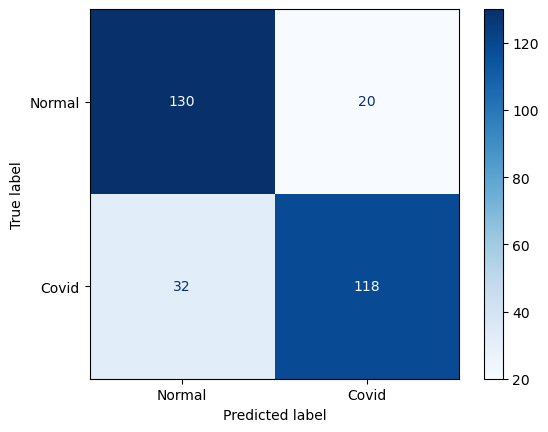

Confusion Matrix Shape: (2, 2)
Confusion Matrix:
 [[130  20]
 [ 40 110]]


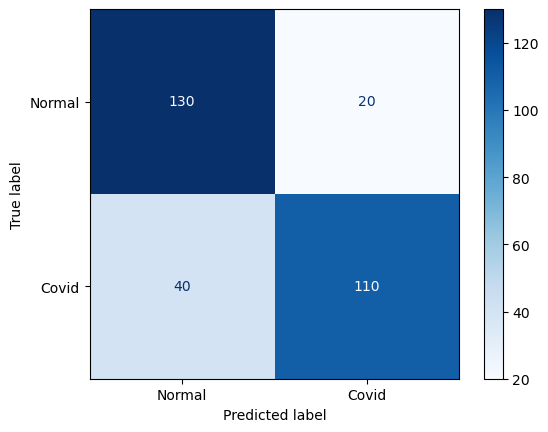

Confusion Matrix Shape: (2, 2)
Confusion Matrix:
 [[128  22]
 [ 28 122]]


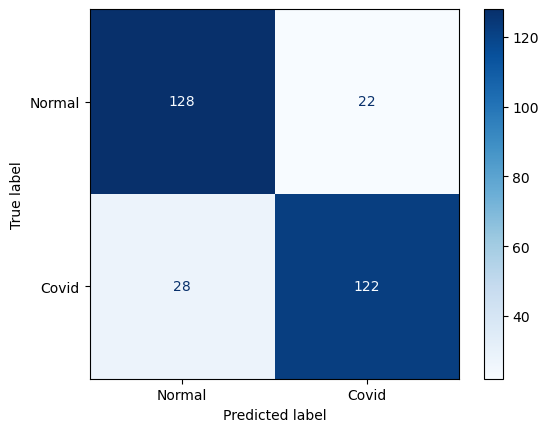

Decision Tree Score: 0.76
Random Forest Score: 0.8333333333333334
SVM Score: 0.8266666666666667
Adaboost Score: 0.8
Confusion Matrix Shape: (2, 2)
Confusion Matrix:
 [[133  17]
 [ 37 113]]


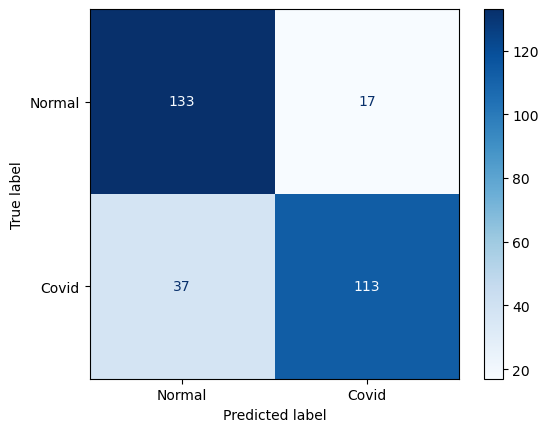

Ensemble Score: 0.82


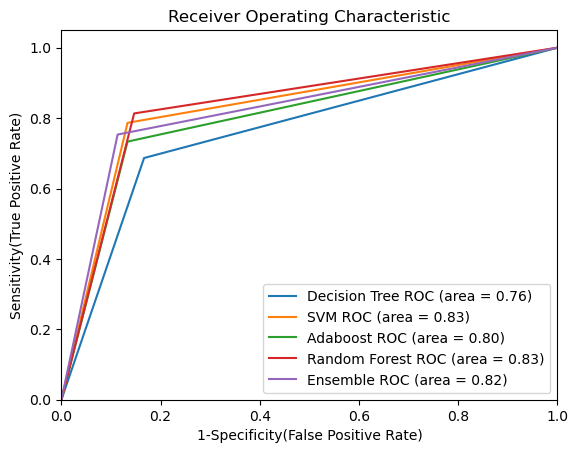

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier as AD
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from sklearn import metrics

def performance_metric_estimation(conf_mat):
    # Ensure the confusion matrix is at least 2x2
    if conf_mat.shape[0] < 2 or conf_mat.shape[1] < 2:
        # If the matrix is too small, pad it with zeros
        padded_mat = np.zeros((2, 2), dtype=int)
        padded_mat[:conf_mat.shape[0], :conf_mat.shape[1]] = conf_mat
        conf_mat = padded_mat

    # Extract confusion matrix elements safely
    TP = conf_mat[0, 0] if conf_mat.shape[0] > 0 and conf_mat.shape[1] > 0 else 0
    FP = conf_mat[0, 1] if conf_mat.shape[0] > 0 and conf_mat.shape[1] > 1 else 0
    FN = conf_mat[1, 0] if conf_mat.shape[0] > 1 and conf_mat.shape[1] > 0 else 0
    TN = conf_mat[1, 1] if conf_mat.shape[0] > 1 and conf_mat.shape[1] > 1 else 0

    # Add small epsilon to avoid division by zero
    epsilon = 1e-7

    # Calculate metrics
    Accuracy_Normal = (TP) / (TP + FN + epsilon)
    Recall_Normal = Accuracy_Normal

    Accuracy_Covid = (TN) / (TN + FP + epsilon)
    Recall_Covid = Accuracy_Covid

    Precision_Normal = (TP) / (TP + FP + epsilon)
    Precision_Covid = (TN) / (TN + FN + epsilon)

    F1_score_Normal = 2 * ((Precision_Normal * Recall_Normal) / (Precision_Normal + Recall_Normal + epsilon))
    F1_score_Covid = 2 * ((Precision_Covid * Recall_Covid) / (Precision_Covid + Recall_Covid + epsilon))

    return Accuracy_Covid, Accuracy_Normal, Recall_Normal, Recall_Covid, \
           Precision_Normal, Precision_Covid, F1_score_Normal, F1_score_Covid

def confusion_matrix_plot(classifier, data, true_label):
    predicted = classifier.predict(data)
    conf_mat = confusion_matrix(true_label, predicted)
    
    print("Confusion Matrix Shape:", conf_mat.shape)
    print("Confusion Matrix:\n", conf_mat)
    
    try:
        a_c, a_n, r_n, r_c, p_n, p_c, F1_n, F1_c = performance_metric_estimation(conf_mat)
        display = ConfusionMatrixDisplay(conf_mat, display_labels=["Normal", "Covid"])
        display.plot(cmap=cm.Blues)
        plt.show()
    except Exception as e:
        print(f"Error processing confusion matrix: {e}")

def ROC_curve_display(classifiers_list, classifier_name, x_train, y_train, x_test, y_test):
    clf_list = []
    for i in range(len(classifier_name)):
        clf_dic = {"clf": classifiers_list[i], "label": classifier_name[i]}
        clf_list.append(clf_dic)
    
    # Below for loop iterates through your models list
    for m in clf_list:
        model = m['clf']  # select the model
        model.fit(x_train, y_train)  # train the model
        y_pred = model.predict(x_test)  # predict the test data
        
        # Compute False positive rate, and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict(x_test))
        
        # Calculate Area under the curve to display on the plot
        auc = metrics.roc_auc_score(y_test, y_pred)
        
        # Now, plot the computed values
        plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity(False Positive Rate)')
    plt.ylabel('Sensitivity(True Positive Rate)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

if __name__ == '__main__':
    # Update these paths to your actual data file paths
    path_train = r"D:\University\Master\Term 3\Computer Vision\HWs\Project I\Improvement\Feature_deep_train.csv"
    path_test = r"D:\University\Master\Term 3\Computer Vision\HWs\Project I\Improvement\Feature_deep_test.csv"

    # Load data using pandas to handle the new CSV structure
    train_df = pd.read_csv(path_train)
    test_df = pd.read_csv(path_test)

    # Extract feature columns (assuming first 64 columns are features)
    train_data = train_df.iloc[:, :64].values
    test_data = test_df.iloc[:, :64].values

    # Extract labels (assuming the 'label' column is the last column before 'image_name')
    train_label = train_df['label'].values
    test_label = test_df['label'].values

    # Scale the features
    scalar = StandardScaler()
    train_data_scaled = scalar.fit_transform(train_data)
    test_data_scaled = scalar.transform(test_data)

    # Print data shapes and label distribution for verification
    print("Train data shape:", train_data_scaled.shape)
    print("Test data shape:", test_data_scaled.shape)
    print("Train label distribution:\n", np.unique(train_label, return_counts=True))
    print("Test label distribution:\n", np.unique(test_label, return_counts=True))

    # decision tree classifier
    clf_dt = DT(random_state=42)
    gs_dt = GridSearchCV(clf_dt, param_grid={'max_leaf_nodes': [2, 10, 15], 
                                            'min_samples_split': [2, 4, 8],
                                            'criterion': ["entropy"], 
                                            'max_depth': [3, 6, 12]})
    gs_dt.fit(train_data_scaled, train_label)
    best_dt = gs_dt.best_estimator_
    confusion_matrix_plot(best_dt, test_data_scaled, test_label)

    # SVM classifier
    clf_svm = svm.SVC(random_state=42, probability=True)
    gs_svm = GridSearchCV(clf_svm, param_grid={'C': [1, 2], 
                                            'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                                            'gamma': [0.01, 0.1, 0.5], 
                                            'degree': [1, 2]})
    gs_svm.fit(train_data_scaled, train_label)
    best_svm = gs_svm.best_estimator_
    confusion_matrix_plot(best_svm, test_data_scaled, test_label)

    # Adaboost classifier
    clf_adaboost = AD(random_state=42, algorithm='SAMME')  # or use 'SAMME.R' if needed
    gs_adaboost = GridSearchCV(clf_adaboost, param_grid={'n_estimators': [50, 100, 250]})
    gs_adaboost.fit(train_data_scaled, train_label)
    best_adaboost = gs_adaboost.best_estimator_
    confusion_matrix_plot(best_adaboost, test_data_scaled, test_label)

    # Random Forest classifier
    clf_rf = RF(random_state=42)
    gs_rf = GridSearchCV(clf_rf, param_grid={'bootstrap': [True, False], 
                                            'max_depth': [10, 50, 100, 150],
                                            'max_features': [2, 4, 6], 
                                            'min_samples_leaf': [2, 4, 6],
                                            'min_samples_split': [2, 4, 10], 
                                            'n_estimators': [10, 50, 100, 150]})
    gs_rf.fit(train_data_scaled, train_label)
    best_rf = gs_rf.best_estimator_
    confusion_matrix_plot(best_rf, test_data_scaled, test_label)

    # Print individual model scores
    print('Decision Tree Score: {}'.format(best_dt.score(test_data_scaled, test_label)))
    print('Random Forest Score: {}'.format(best_rf.score(test_data_scaled, test_label)))
    print('SVM Score: {}'.format(best_svm.score(test_data_scaled, test_label)))
    print('Adaboost Score: {}'.format(best_adaboost.score(test_data_scaled, test_label)))

    # Ensemble classifier
    estimators = [('rf', best_rf), 
                ('adaboost', best_adaboost), 
                ('decision tree', best_dt), 
                ('svm', best_svm)]
    ensemble = VotingClassifier(estimators=estimators, voting='hard')
    ensemble.fit(train_data_scaled, train_label)
    confusion_matrix_plot(ensemble, test_data_scaled, test_label)
    print("Ensemble Score:", ensemble.score(test_data_scaled, test_label))

    # ROC Curve
    classifier_list = [best_dt, best_svm, best_adaboost, best_rf, ensemble]
    classifier_name = ["Decision Tree", "SVM", "Adaboost", "Random Forest", "Ensemble"]
    ROC_curve_display(classifier_list, classifier_name, train_data_scaled, train_label, test_data_scaled, test_label)


1/1 [==============================] - 0s 68ms/step
Features extracted and saved to D:\University\Master\Term 3\Computer Vision\HWs\Project I\Improvement\Feature_deep_train.csv
Total samples: 2100
Class distribution:
Covid: 1050
Normal: 1050

Label distribution in saved CSV:
label
1    1050
0    1050
Name: count, dtype: int64


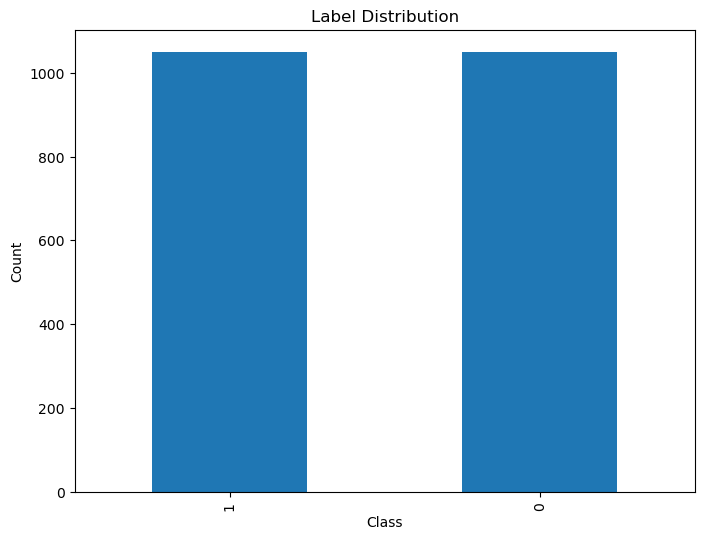

1/1 [==============================] - 0s 66ms/step
Features extracted and saved to D:\University\Master\Term 3\Computer Vision\HWs\Project I\Improvement\Feature_deep_test.csv
Total samples: 300
Class distribution:
Covid: 150
Normal: 150

Label distribution in saved CSV:
label
1    150
0    150
Name: count, dtype: int64


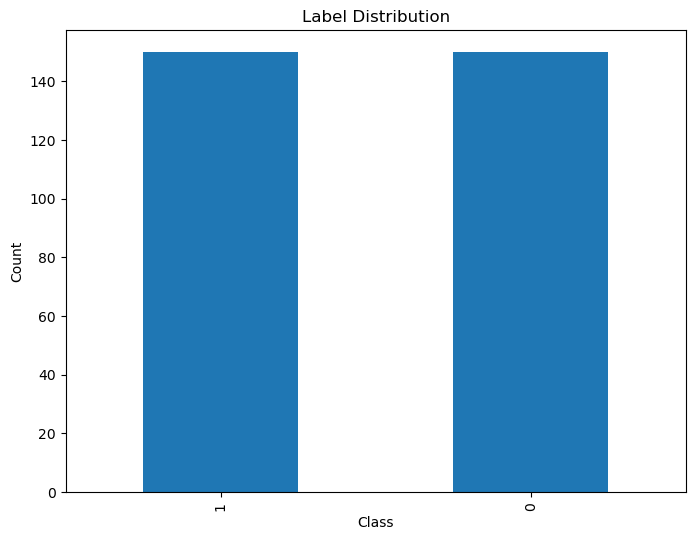

In [1]:
#Feature extr v2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import pandas as pd
import matplotlib.pyplot as plt

# Load the trained Keras model
model = load_model(r'D:\University\Master\Term 3\Computer Vision\HWs\Project I\Final Attempt\cnn_model2.h5')

# Function to preprocess image for prediction
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image
    return img_array

# Feature extraction function for a given layer in the Keras model
def extract_features(img_path, model, layer_name='dense'):
    # Preprocess the image
    img_array = preprocess_image(img_path)
    
    # Create a new model that ends at the layer you're interested in
    feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    
    # Get features
    features = feature_extractor.predict(img_array)
    return features.flatten()

# Function to process dataset and extract features
def process_dataset(main_path, output_file):
    # Prepare to store features and labels
    all_features = []
    all_labels = []
    image_names = []
    class_counts = {}

    # Loop through the dataset folder
    for root, subfolders, filenames in os.walk(main_path):
        for folder in subfolders:
            filepath = os.path.join(root, folder) + "/*"
            paths = glob.glob(filepath)
            
            # Assign class label (0 for Normal, 1 for COVID)
            if folder.lower() == 'covid':
                label = 1
            elif folder.lower() == 'normal':
                label = 0
            else:
                print(f"Skipping folder: {folder}")
                continue

            # Track class counts
            class_counts[folder] = len(paths)

            # Loop through images and extract features
            for img_path in paths:
                try:
                    # Extract features using the Keras model
                    f_vector = extract_features(img_path, model)
                    
                    # Store features, label, and image name
                    all_features.append(f_vector)
                    all_labels.append(label)
                    image_names.append(os.path.basename(img_path))
                    
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

    # Convert to DataFrame for easy CSV export
    feature_df = pd.DataFrame(all_features)
    feature_df['label'] = all_labels
    feature_df['image_name'] = image_names

    # Save to CSV
    feature_df.to_csv(output_file, index=False)
    
    # Detailed logging
    print(f"Features extracted and saved to {output_file}")
    print(f"Total samples: {len(feature_df)}")
    print("Class distribution:")
    for folder, count in class_counts.items():
        print(f"{folder}: {count}")
    print("\nLabel distribution in saved CSV:")
    print(feature_df['label'].value_counts())

    # Visualize label distribution
    plt.figure(figsize=(8, 6))
    feature_df['label'].value_counts().plot(kind='bar')
    plt.title('Label Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

# Paths for train and test datasets
train_path = r'D:\University\Master\Term 3\Computer Vision\HWs\Project I\Improvement\MachineVision Dataset\Final dataset seperated\Train'
test_path = r'D:\University\Master\Term 3\Computer Vision\HWs\Project I\Improvement\MachineVision Dataset\Final dataset seperated\Test'

# Output CSV files
train_output = r'D:\University\Master\Term 3\Computer Vision\HWs\Project I\Improvement\Feature_deep_train.csv'
test_output = r'D:\University\Master\Term 3\Computer Vision\HWs\Project I\Improvement\Feature_deep_test.csv'

# Import glob here to avoid potential import issues
import glob

# Extract features for train and test datasets
process_dataset(train_path, train_output)
process_dataset(test_path, test_output)


In [3]:
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import os

class COVIDClassificationApp:
    def __init__(self, master):
        self.master = master
        master.title("COVID-19 X-ray Classification")
        master.geometry("800x600")
        master.configure(bg='#5af6f1')

        # Load pre-trained TensorFlow model
        self.save_path = r'C:\Users\Sajad\MVProject\cnn_model2.h5'  # Update this with your actual model path
        self.model = load_model(self.save_path)

        # Image preprocessing transformations
        self.input_shape = (224, 224)  # Adjust based on your model's input size

        # Create UI components
        self.create_widgets()

    def create_widgets(self):
        # Image Display Frame
        self.image_frame = tk.Frame(self.master, width=500, height=400, bg='white', relief=tk.RAISED, borderwidth=2)
        self.image_frame.pack(pady=20)
        self.image_frame.pack_propagate(False)

        self.image_label = tk.Label(self.image_frame, text="No Image Selected", bg='white')
        self.image_label.pack(expand=True)

        # Button Frame
        button_frame = tk.Frame(self.master, bg='#5af6f1')
        button_frame.pack(pady=10)

        # Select Image Button
        select_button = tk.Button(button_frame, text="Select Image", command=self.select_image, 
                                  bg='#fc1b55', fg='white', font=('Arial', 12))
        select_button.pack(side=tk.LEFT, padx=10)

        # Classify Button
        classify_button = tk.Button(button_frame, text="Classify Image", command=self.classify_image, 
                                    bg='#2e33da', fg='white', font=('Arial', 12))
        classify_button.pack(side=tk.LEFT, padx=10)

        # Result Frame
        self.result_frame = tk.Frame(self.master, width=600, height=100, bg='#00c9cc', relief=tk.SUNKEN, borderwidth=2)
        self.result_frame.pack(pady=10)
        self.result_frame.pack_propagate(False)

        self.result_label = tk.Label(self.result_frame, text="Classification Result", 
                                     bg='#00c9cc',fg='white', font=('Arial', 14))
        self.result_label.pack(expand=True)

        # Class labels
        self.class_labels = ["Normal", "COVID-19"]

        # Store selected image path
        self.selected_image_path = None

    def select_image(self):
        # Open file dialog to select image
        file_path = filedialog.askopenfilename(
            title="Select X-ray Image",
            filetypes=[("Image files", "*.png *.jpg *.jpeg *.bmp *.tiff")]
        )
        
        if file_path:
            self.selected_image_path = file_path
            # Display selected image
            image = Image.open(file_path)
            image.thumbnail((500, 400))  # Resize for display
            photo = ImageTk.PhotoImage(image)
            
            self.image_label.configure(image=photo)
            self.image_label.image = photo  # Keep a reference
            
            # Reset result label
            self.result_label.configure(text="Image Selected. Ready to Classify.")

    def classify_image(self):
        if not self.selected_image_path:
            messagebox.showwarning("Warning", "Please select an image first!")
            return

        try:
            # Open and preprocess image
            image = Image.open(self.selected_image_path).convert('RGB')
            image = image.resize(self.input_shape)  # Resize to match model input
            
            # Convert to numpy array and normalize
            img_array = img_to_array(image)
            img_array = img_array / 255.0  # Normalize to [0,1]
            img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

            # Perform classification
            prediction = self.model.predict(img_array)
            predicted_class = np.argmax(prediction, axis=1)[0]
            confidence = np.max(prediction) * 100

            # Update result label
            result_text = f"Prediction: {self.class_labels[predicted_class]}\n" \
                          f"Confidence: {confidence:.2f}%"
            self.result_label.configure(text=result_text, fg='green')

        except Exception as e:
            messagebox.showerror("Error", f"An error occurred: {str(e)}")

def main():
    root = tk.Tk()
    app = COVIDClassificationApp(root)
    root.mainloop()

if __name__ == "__main__":
    main()


1/1 [==============================] - 1s 755ms/step
